In [2]:
import pandas as pd
import re
import os
import glob

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [46]:
def merge_region(region='PFC',condition="MC",blacklist=['Doublet','NN']):
    df_result = pd.DataFrame()
    files = glob.glob(f'/data2st1/junyi/output/atac0416/dar/{region}*{condition}_wilcoxon.csv')
    for file in files:
        if any([file.find(black) > -1 for black in blacklist]):
            continue
        df_dar = pd.read_csv(file,index_col=0)

        ctname = file.split('/')[-1].replace('.csv', '')
        ctname = "_".join(ctname.split('_')[1:-2])
        if len(df_dar) == 0:
            continue
        df_dar['ctname'] = ctname
        df_result = pd.concat([df_result, df_dar], axis=0, ignore_index=True)
    df_result['region'] = region
    df_result['condition'] = condition
    return df_result


In [47]:
df_PFC_MC = merge_region(region='PFC',condition="MC")
df_PFC_MW = merge_region(region='PFC',condition="MW")

In [70]:
df_HIP_MC = merge_region(region='HIP',condition="MC")
df_HIP_MW = merge_region(region='HIP',condition="MW")

In [50]:
df_AMY_MC = merge_region(region='AMY',condition="MC")
df_AMY_MW = merge_region(region='AMY',condition="MW")

In [72]:
df_DAR_ALL = pd.concat([df_PFC_MC, df_PFC_MW, df_HIP_MC, df_HIP_MW, df_AMY_MC, df_AMY_MW], axis=0, ignore_index=True)

In [74]:
df_counts = df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

In [99]:
df_counts.sort_values(by=['region','condition','counts'])

,ctname,condition,region,counts
21,Immune,MC,AMY,1
1,AMY_Dach1_Glut,MC,AMY,3
7,AMY_Sox6_GABA,MC,AMY,3
0,AMY_Adamtsl1_Glut,MC,AMY,4
3,AMY_Gad2_GABA,MC,AMY,102
5,AMY_Slc17a6_Glut,MC,AMY,597
2,AMY_Dach1_Glut,MW,AMY,1
4,AMY_Gad2_GABA,MW,AMY,12
8,AMY_Tafa1_Glut,MW,AMY,16
6,AMY_Slc17a6_Glut,MW,AMY,29


/tmp/ipykernel_1994041/432591432.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)


(0.0, 1000.0)

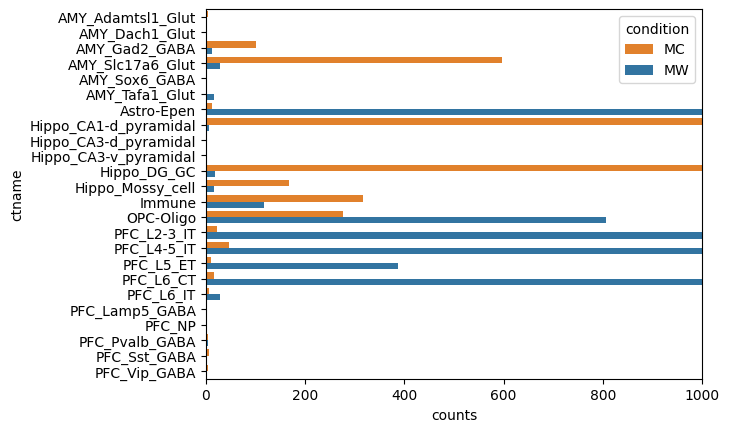

In [111]:
sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)
plt.xlim (0, 1000)


/tmp/ipykernel_1994041/4233344945.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x="ctname",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)


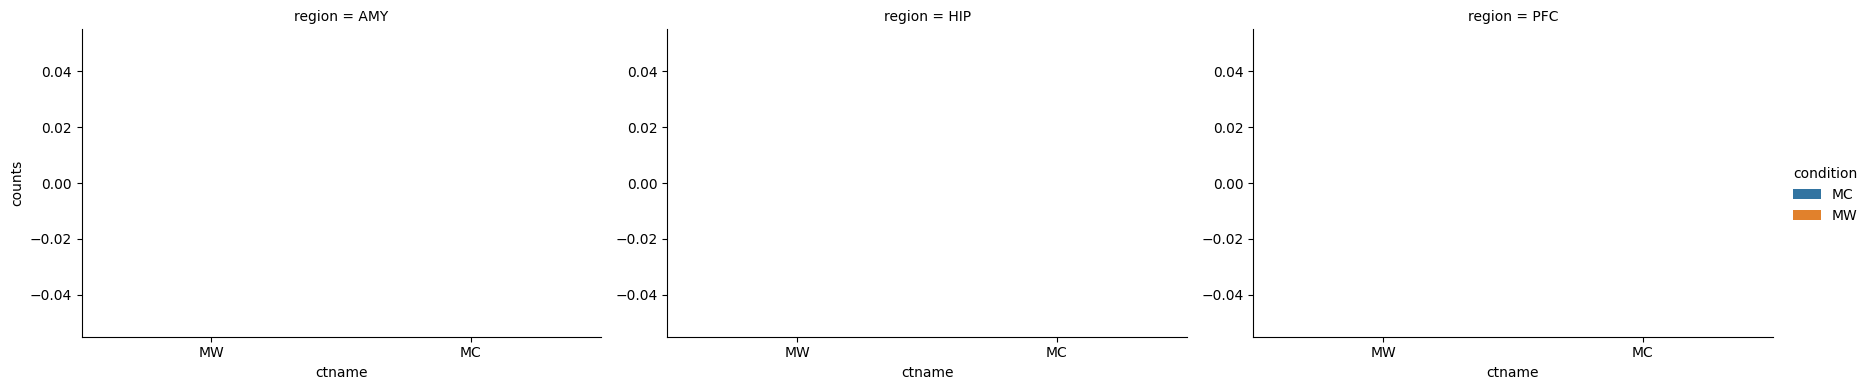

In [ ]:
sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)

In [7]:
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover

    temp_df = df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True)
    temp_df['ID'] = temp_df.index
    temp_df.to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

/tmp/ipykernel_2604088/102094875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
/tmp/ipykernel_2604088/102094875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
/tmp/ipykernel_2604088/102094875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dar_filtered.sort_values(

In [ ]:
def merge_region(region='PFC',condition="MC",blacklist=['Doublet']):


In [ ]:
# import subprocess
# files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR.bed')
# for filename in files:
#     experimentname = re.split(r'[./]', filename)[-2]
#     folder_name = os.path.dirname(filename)

#     #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

#     command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
#     print(command_str)
#     subprocess.run(command_str, shell=True)

/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_unmap.bed


Reading liftover chains
Mapping coordinates


/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_Immune_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_Immune_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_Immune_wilcoxon_DAR_unmap.bed


Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_Astro-Epen_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_Astro-Epen_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_Astro-Epen_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR_unmap.bed


Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_Vascular_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_Vascular_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_Vascular_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_unmap.bed


Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [9]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_Astro-Epen_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_Astro-Epen_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_Immune_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_Immune_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/ALL_Vascu

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_gene.bed

In [11]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/motif/','--write_html']
    print(command_str)
    subprocess.run(command_str)
    
# !pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
# --bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
# --species 'mus_musculus' \
# --auc_threshold 0.005 \
# --nes_threshold 3.0 \
# --rank_threshold 0.05 \
# --path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
# --output_folder '/data2st1/junyi/output/motif/' \
# --write_html 

['pycistarget', 'cistarget', '--cistarget_db_fname', '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather', '--bed_fname', '/data2st1/junyi/output/motif/ALL_OPC-Oligo_wilcoxon_DAR_lifted.bed', '--species', 'mus_musculus', '--auc_threshold', '0.005', '--nes_threshold', '3.0', '--rank_threshold', '0.05', '--path_to_motif_annotations', '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl', '--output_folder', '/data2st1/junyi/output/motif/', '--write_html']
2025-04-01 17:03:14,444 cisTarget    INFO     Reading cisTarget database
2025-04-01 17:04:59,437 cisTarget    INFO     Running cisTarget for ALL_OPC-Oligo_wilcoxon_DAR_lifted which has 13335 regions
2025-04-01 17:05:24,221 cisTarget    INFO     Annotating motifs for ALL_OPC-Oligo_wilcoxon_DAR_lifted
2025-04-01 17:05:27,369 cisTarget    INFO     Getting cistromes for ALL_OPC-Oligo_wilcoxon_DAR_lifted
['pycistarget', 'cistarget', '--cistarget_db_fname', '/data2st1/junyi/scen

In [64]:
import h5py
dict_table = {}
cell_types = ['Neuron','Astro-Epen','Vascular','Immune','OPC-Oligo']
for celltype in cell_types:
    with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_ALL_{celltype}_wilcoxon_DAR_lifted.hdf5', 'r') as f:
        # Open the HDF5 file
        # List all groups and datasets in the file
        print("Keys in the file:", list(f.keys()))
        

        # # Access a specific dataset
        expname = f'ALL_{celltype}_wilcoxon_DAR_lifted'
        dataset = f[expname]  # Replace with your dataset name
        # print("Shape of the dataset:", dataset.shape)
        # print("Data type of the dataset:", dataset.dtype)
        dict_dataset = {}
        #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

        table = f[expname]['motif_enrichment']['table'][:]
        for key in dataset.keys():
            dict_dataset[key] = dataset[key]
        # print("Data:", data)
        dict_table[expname] = table

Keys in the file: ['ALL_Neuron_wilcoxon_DAR_lifted']
Keys in the file: ['ALL_Astro-Epen_wilcoxon_DAR_lifted']
Keys in the file: ['ALL_Vascular_wilcoxon_DAR_lifted']
Keys in the file: ['ALL_Immune_wilcoxon_DAR_lifted']
Keys in the file: ['ALL_OPC-Oligo_wilcoxon_DAR_lifted']


In [ ]:
for keys in dict_table.keys():
    print(keys)
    print(dict_table[keys][:5])
    #Astro : id, orthology, direcrt, id, msimilarity,logo
    #Neuron : id,logo,orthology, id, direct, msimilarity
    #Vascular : id,logo,orthology,msimilarity,id, direct

ALL_Neuron_wilcoxon_DAR_lifted
[(b'metacluster_136.3', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_136.3.png" width="200" >'], [b'Rfx5, Rfx3, Rfx6, Zbtb7b, Srebf1, Rfx4, Rfx8, Rfx1, Mxi1, Rfx2, Max'], [b'ALL_Neuron_wilcoxon_DAR_lifted'], [b'Rfx6, Rfx3, Rfx7, Rfx4, Rfx1, Rfx2'], [b'Rfx5, Rfx3, Rfx6, Rfx7, Rfx4, Rfx1, Rfx2'], [1.51315720e+01, 1.77283944e-02, 3.36720000e+04], [6285])
 (b'metacluster_136.2', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_136.2.png" width="200" >'], [b'Rfx5, Rfx3, Rfxank, Rfx7, Rfx2, Rfxap'], [b'ALL_Neuron_wilcoxon_DAR_lifted'], [b'Rfx5, Rfx3, Rfx4, Rfx1, Rfx2'], [b'Rfx6, Rfx3, Rfx7, Rfx4, Rfx1, Rfx2'], [1.07323284e+01, 1.34454913e-02, 5.05940000e+04], [7092])
 (b'metacluster_63.3', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_63.3.png" width="200" >'], [b'Rfx6, Rfx3, Rfx4, Rfx8, Rfx1, Rfx2'], [b'ALL_Neuron_wilcoxon_DAR_lifted'], [b'Rfx6, Rfx2'], [b'Rf

In [ ]:
list_table = []
list_key = []
list_TFs = []

df_TF_celltype = pd.DataFrame()

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0].decode('utf-8'))
        list_key.append(key)
        TFs_tmp=[]
        for i in range(1, len(row)-2):
            if 'img' in row[i][0].decode('utf-8') or 'wilcoxon' in row[i][0].decode('utf-8'):
                continue
            TFs_tmp+=([ tf.decode('utf-8') for tf in row[i]])

        df_tfs = pd.DataFrame({'TF':",".join(TFs_tmp).split(',')})
        df_tfs['NES'] = row[-2][0]
        df_tfs['AUC'] = row[-2][1]
        df_tfs['Rank'] = row[-2][2]
        df_tfs['celltype.L1'] = key.split('_')[1]
        df_tfs['id'] = row[0].decode('utf-8')

        list_TFs.append(set(TFs_tmp))
        df_TF_celltype = pd.concat([df_TF_celltype,df_tfs],axis=0)
        
df_TF = pd.DataFrame({'TF':list_table,'key':list_key,'TFs':list_TFs})

In [161]:
df_TF_celltype.drop_duplicates(inplace=True)


In [165]:
df_TF_celltype

,TF,NES,AUC,Rank,celltype.L1,id
0,Rfx5,15.131572,0.017728,33672.0,Neuron,metacluster_136.3
1,Rfx3,15.131572,0.017728,33672.0,Neuron,metacluster_136.3
2,Rfx6,15.131572,0.017728,33672.0,Neuron,metacluster_136.3
3,Zbtb7b,15.131572,0.017728,33672.0,Neuron,metacluster_136.3
4,Srebf1,15.131572,0.017728,33672.0,Neuron,metacluster_136.3
...,...,...,...,...,...,...
7,nan,3.029071,0.012543,55314.0,OPC-Oligo,metacluster_3.10
0,nan,3.007995,0.012486,12218.0,OPC-Oligo,swissregulon__hs__YBX1
1,Ybx1,3.007995,0.012486,12218.0,OPC-Oligo,swissregulon__hs__YBX1
0,nan,3.007340,0.012484,9524.0,OPC-Oligo,transfac_pro__M02279


In [166]:
df_RSS = pd.read_csv("/home/junyichen/code/scmmd/data/RSS_Score(only pos).csv",index_col=0)

In [167]:
df_RSS['TF']=df_RSS['Topic'].str.replace('[()+]','')

/tmp/ipykernel_2604088/2324044925.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RSS['TF']=df_RSS['Topic'].str.replace('[()+]','')


In [168]:
cell_to_category = {
    # Astro-Epen
    'Astro-Gfaphigh': 'Astro-Epen',
    'Astro-TE': 'Astro-Epen',
    
    # Immune
    'Microglia': 'Immune',
    'PVM': 'Immune',
    
    # Neuron
    'L2/3 IT': 'Neuron',
    'L4/5 IT': 'Neuron',
    'L5 ET': 'Neuron',
    'L6 CT': 'Neuron',
    'L6 IT': 'Neuron',
    'L6b': 'Neuron',
    'Lamp5 GABA': 'Neuron',
    'Pvalb GABA': 'Neuron',
    'Pvalb Vipr2 GABA': 'Neuron',
    'Sst GABA': 'Neuron',
    'Vip GABA': 'Neuron',
    
    # OPC-Oligo
    'COP': 'OPC-Oligo',
    'MFOL': 'OPC-Oligo',
    'MOL': 'OPC-Oligo',
    'NFOL': 'OPC-Oligo',
    'NP': 'OPC-Oligo',
    'OPC': 'OPC-Oligo',
    
    # Vascular
    'Arachnoid barrier cell': 'Vascular',
    'Car3': 'Vascular',
    'Endothelial cell': 'Vascular',
    'Pericyte': 'Vascular',
    'VLMC': 'Vascular'
}

In [169]:
df_RSS['celltype.L1'] = df_RSS['celltype.L2'].map(cell_to_category)


In [197]:
df_TF_celltype.groupby(['celltype.L1']).nunique()

,TF,NES,AUC,Rank,id
celltype.L1,,,,,
Astro-Epen,216,76,76,76,76
Immune,238,112,112,96,112
Neuron,179,64,64,62,64
OPC-Oligo,185,95,95,92,95
Vascular,42,33,33,33,33


In [194]:
df_RSS.groupby(['celltype.L1']).nunique()

,Topic,celltype.L2,RSS,Z,TF
celltype.L1,,,,,
Astro-Epen,62,2,124,70,62
Immune,62,2,124,46,62
Neuron,62,11,682,234,62
OPC-Oligo,62,6,371,146,62
Vascular,62,5,310,144,62


In [199]:
df_merged = df_RSS.merge(df_TF_celltype,left_on=['TF','celltype.L1'],right_on=['TF','celltype.L1'],how='inner')

In [174]:
df_merged.sort_values(by='RSS',ascending=False,inplace=True)

In [185]:
df_merged.drop_duplicates(set(['TF','celltype.L1']),keep='first').to_csv('/data2st1/junyi/output/motif/TF_RSS.csv',index=False)

In [200]:
df_merged.groupby('celltype.L1').nunique()

,Topic,celltype.L2,RSS,Z,TF,NES,AUC,Rank,id
celltype.L1,,,,,,,,,
Astro-Epen,10,2,20,12,10,16,16,16,16
Immune,7,2,14,8,7,14,14,14,14
Neuron,6,11,66,20,6,7,7,7,7
OPC-Oligo,4,6,24,4,4,13,13,13,13
Vascular,1,5,5,2,1,1,1,1,1


In [152]:
ct = pd.crosstab(df_merged['celltype'],df_merged['celltype.L1'],values=df_merged['RSS'],aggfunc='count')

In [201]:
ct

celltype.L1,Astro-Epen,Immune,Neuron,OPC-Oligo,Vascular
celltype,,,,,
Astro-Epen,34,34,187,102,85
Immune,32,32,176,96,80
Neuron,16,16,88,48,40
OPC-Oligo,32,32,176,96,80
Vascular,4,4,22,12,10


In [142]:
set(df_merged['celltype']
)

{'Astro-Epen', 'Immune', 'Neuron', 'OPC-Oligo', 'Vascular'}

In [10]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

bedtools closest -a /data2st1/junyi/output/motif/ALL_Vascular_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/ALL_Vascular_wilcoxon_DAR_lifted_sorted_gene.bed
bedtools closest -a /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/ALL_all_MC_wilcoxon_DAR_lifted_sorted_gene.bed
bedtools closest -a /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/ALL_all_MW_wilcoxon_DAR_lifted_sorted_gene.bed
bedtools closest -a /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/ALL_Neuron_wilcoxon_DAR_lifted_sorted_gene.bed
bedtools closest -a /data2st1/junyi/output/motif

In [33]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html 

13824.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2025-03-13 21:58:09,940 cisTarget    INFO     Reading cisTarget database
2025-03-13 21:58:19,222 cisTarget    INFO     Running cisTarget for AMY_Neuron_MC_wilcoxon_DAR_lifted which has 12 regions
2025-03-13 21:58:25,512 cisTarget    INFO     Annotating motifs for AMY_Neuron_MC_wilcoxon_DAR_lifted
2025-03-13 21:58:26,898 cisTarget    INFO     Getting cistromes for AMY_Neuron_MC_wilcoxon_DAR_lifted


In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon.csv')
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover
    df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True).to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

In [73]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    folder_name = os.path.dirname(filename)

    #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

    command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
    print(command_str)
    subprocess.run(command_str, shell=True)

/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Immune_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Immune_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Immune_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Astro-Epen_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Astro-Epen_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_Astro-Epen_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_OPC-Oligo_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_OPC-Oligo_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_OPC-Oligo_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Astro-Epen_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Astro-Epen_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Astro-Epen_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_OPC-Oligo_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_OPC-Oligo_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_OPC-Oligo_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_unmap.bed
/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Immune_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Immune_MW_wilcoxon_DAR_lifted.bed /data2st1

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [83]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_OPC-Oligo_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_OPC-Oligo_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/PFC_Immune_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/PFC_Immune_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_Immune_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_Immune_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/PFC_Astro-Epen_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/PFC_Astro-Epen_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_Astro-Epen_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_Astro-Epen_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -k2,2n /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted_sorted.bed
sort -k1,1 -

In [ ]:
# from pyliftover import LiftOver
# lo = LiftOver('/data2st1/junyi/mm10ToMm39.over.chain.gz')
# lo.convert_coordinate('chr1', 1000000, '-')


In [188]:
result_frame = pd.DataFrame()
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted_gene.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    region = re.split(r'_',experimentname)[0]
    celltype = re.split(r'_',experimentname)[1]
    condition = re.split(r'_',experimentname)[2]
    try:
        df = pd.read_csv(filename,sep='\t',header=None)
    except:
        continue
    df.columns = ['chrom','start','end','chrom2','start2','end2','score','starnd','gene_name','gene_id','annotation','distance']
    df['region'] = region
    df['celltype'] = celltype
    df['condition'] = condition
    df['name'] = df['chrom'] + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)
    # df_score = pd.read_csv(f"/data2st1/junyi/output/motif/{region}_{celltype}_{condition}_wilcoxon.csv",index_col=0)
    # df['logfoldchanges'] = df_score.set_index('names').loc[df['name'],'logfoldchanges'].values
    # df['pvals'] = df_score.set_index('names').loc[df['name'],'pvals'].values
    result_frame = pd.concat([result_frame,df])

(0.0, 6000.0)

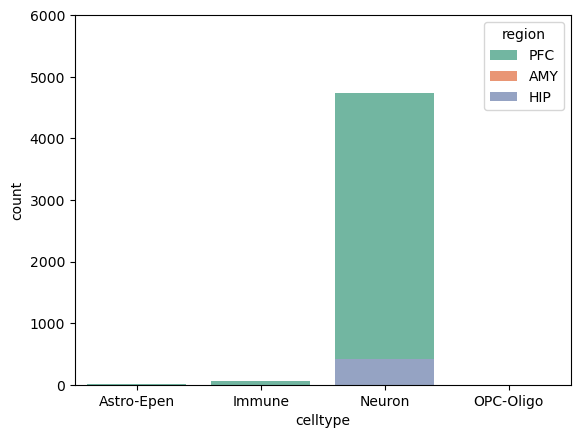

In [189]:
ax = sns.countplot(data=result_frame, x='celltype', hue='region', dodge=False, palette='Set2',)
ax.set_ylim(0,6000)


In [190]:
keep1=result_frame.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])

In [191]:
keep1['generegion'] = 'genebody'
keep1.loc[keep1['distance']<0,'generegion'] = 'downstream'
promoter = keep1.loc[(keep1['distance']>0) & (keep1['distance']<=2000) & (keep1['starnd']=='+')].index
distal = keep1.loc[(keep1['distance']>0) & (keep1['distance']>=2000) & (keep1['starnd']=='+')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'

promoter = keep1.loc[(keep1['distance']<0) & (keep1['distance']>=-2000) & (keep1['starnd']=='-')].index
distal = keep1.loc[(keep1['distance']<0) & (keep1['distance']<=-2000) & (keep1['starnd']=='-')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'


In [192]:
keep1=keep1.loc[keep1['start2']>0]

In [193]:
keep1.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])

,chrom,start,end,chrom2,start2,end2,score,starnd,gene_name,gene_id,annotation,distance,region,celltype,condition,name,generegion
0,chr11,69062814,69063315,chr11,69059716,69061578,.,+,Borcs6,ENSMUSG00000045176.3,genebody,-1237,PFC,Astro-Epen,MW,chr11:69062814-69063315,downstream
739,chr11,80304784,80305285,chr11,80300911,80355955,.,+,Rhbdl3,ENSMUSG00000017692.8,genebody,0,PFC,Neuron,MW,chr11:80304784-80305285,genebody
746,chr11,83872103,83872604,chr11,83850062,83905819,.,+,Hnf1b,ENSMUSG00000020679.11,genebody,0,PFC,Neuron,MW,chr11:83872103-83872604,genebody
750,chr11,85492254,85492755,chr11,85353166,85826058,.,+,Bcas3,ENSMUSG00000059439.15,genebody,0,PFC,Neuron,MW,chr11:85492254-85492755,genebody
751,chr11,85642572,85643073,chr11,85353166,85826058,.,+,Bcas3,ENSMUSG00000059439.15,genebody,0,PFC,Neuron,MW,chr11:85642572-85643073,genebody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,chr5,29378161,29378662,chr5,29229801,29378390,.,-,Lmbr1,ENSMUSG00000010721.15,genebody,0,HIP,Neuron,MW,chr5:29378161-29378662,genebody
56,chr9,4260157,4260658,chr9,4271129,4271237,.,-,Gm22195,ENSMUSG00000080511.1,genebody,10472,PFC,Immune,MW,chr9:4260157-4260658,genebody
289,chr5,44537924,44538425,chr5,44472131,44799680,.,-,Ldb2,ENSMUSG00000039706.11,genebody,0,HIP,Neuron,MW,chr5:44537924-44538425,genebody
60,chrX,73659029,73659530,chrX,73655993,73660117,.,-,Pnck,ENSMUSG00000002012.13,genebody,0,PFC,Immune,MW,chrX:73659029-73659530,genebody


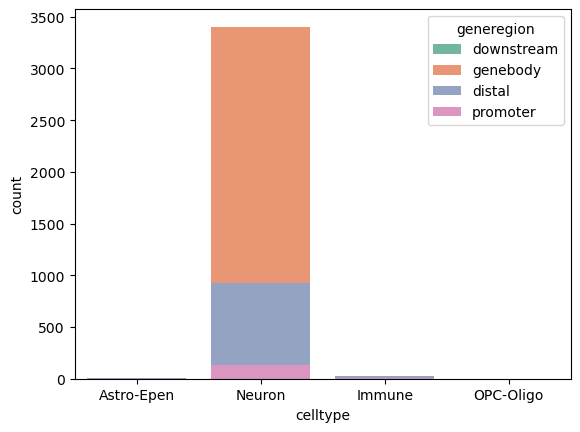

In [198]:
ax = sns.countplot(data=keep1, x='celltype', hue='generegion', dodge=False, palette='Set2',)

In [94]:
pd.read_csv('/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon.csv',index_col=0)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,chr2:98497263-98497764,12.810204,0.177136,1.437576e-37,5.497807e-32,0.971026,0.969089
1,chrY:90819855-90820356,12.009475,0.663373,3.168512e-33,6.058765e-28,0.241490,0.166957
2,chr9:3024256-3024757,10.900932,0.206880,1.140825e-27,1.454308e-22,0.683944,0.638851
3,chr6:145133176-145133677,9.897700,1.143716,4.259550e-23,4.072514e-18,0.118428,0.054718
4,chrY:90772715-90773216,6.637759,0.619698,3.184887e-11,1.995405e-06,0.132514,0.089804
...,...,...,...,...,...,...,...
79,chr12:17594476-17594977,-6.306709,-0.155206,2.850303e-10,1.090059e-05,0.401989,0.443039
80,chr16:24290209-24290710,-6.469603,-1.016241,9.826080e-11,4.175385e-06,0.032186,0.074349
81,chr16:21023066-21023567,-6.576906,-0.260039,4.803376e-11,2.296230e-06,0.244147,0.284308
82,chr6:28929338-28929839,-6.617537,-1.360350,3.652334e-11,1.995405e-06,0.034596,0.076530


In [ ]:
# Convert hg38 to hg19
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_unmap.bed


Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [40]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

2025-03-13 11:46:41,507 cisTarget    INFO     Reading cisTarget database
2025-03-13 11:46:52,501 cisTarget    INFO     Running cisTarget for HIP_Neuron_MW_wilcoxon_DAR_lifted which has 361 regions
2025-03-13 11:46:58,533 cisTarget    INFO     Annotating motifs for HIP_Neuron_MW_wilcoxon_DAR_lifted
2025-03-13 11:47:00,109 cisTarget    INFO     Getting cistromes for HIP_Neuron_MW_wilcoxon_DAR_lifted


In [41]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

2025-03-13 11:47:03,296 cisTarget    INFO     Reading cisTarget database
2025-03-13 11:47:15,062 cisTarget    INFO     Running cisTarget for AMY_Neuron_MW_wilcoxon_DAR_lifted which has 61 regions
2025-03-13 11:47:21,582 cisTarget    INFO     Annotating motifs for AMY_Neuron_MW_wilcoxon_DAR_lifted
2025-03-13 11:47:22,984 cisTarget    INFO     Getting cistromes for AMY_Neuron_MW_wilcoxon_DAR_lifted


In [31]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

13707.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2025-03-13 21:56:13,534 cisTarget    INFO     Reading cisTarget database
2025-03-13 21:57:17,011 cisTarget    INFO     Running cisTarget for PFC_Neuron_MW_wilcoxon_DAR_lifted which has 4627 regions
2025-03-13 21:57:22,624 cisTarget    INFO     Annotating motifs for PFC_Neuron_MW_wilcoxon_DAR_lifted
2025-03-13 21:57:24,254 cisTarget    INFO     Getting cistromes for PFC_Neuron_MW_wilcoxon_DAR_lifted


In [2]:
import h5py
import copy

regions = ['AMY','HIP','PFC']
celltypes = ['Neuron']

dict_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

            table = f[expname]['motif_enrichment']['table'][:]
            for key in dataset.keys():
                dict_dataset[key] = dataset[key]
            # print("Data:", data)
            dict_table[expname] = table

Keys in the file: ['AMY_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['HIP_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['PFC_Neuron_MC_wilcoxon_DAR_lifted']


In [3]:
for i in dict_table['AMY_Neuron_MC_wilcoxon_DAR_lifted']:
    print(i[0])

b'metacluster_33.8'
b'transfac_pro__M07270'
b'hdpi__RARB'
b'metacluster_82.3'
b'transfac_pro__M04886'
b'transfac_pro__M05556'
b'taipale_tf_pairs__GCM1_MAX_RTGCGGGNNNNNNNCACGTGN_CAP_repr'
b'taipale_tf_pairs__ETV5_HES7_CCGGAANNNNNNCACGTG_CAP'
b'transfac_pro__M04893'
b'taipale_tf_pairs__ETV5_FOXI1_TGTTGNCGGAWRN_CAP'
b'cisbp__M00135'
b'transfac_pro__M02090'
b'hdpi__FLI1'
b'transfac_pro__M06833'
b'transfac_pro__M02898'
b'taipale_tf_pairs__GCM1_MAX_RTGCGGGNNNNNNNCACGTGN_CAP'
b'cisbp__M00139'
b'metacluster_126.3'
b'cisbp__M08213'
b'tfdimers__MD00144'
b'transfac_pro__M12653'
b'jaspar__MA0185.1'
b'tfdimers__MD00521'
b'transfac_pro__M01238'
b'homer__TGGTACATTCCA_PRDM10'
b'metacluster_61.1'
b'transfac_public__M00471'
b'transfac_pro__M00980'
b'metacluster_115.1'
b'transfac_pro__M05956'
b'transfac_pro__M02087'
b'tfdimers__MD00398'
b'hocomoco__MLX_HUMAN.H11MO.0.D'
b'transfac_pro__M06073'
b'metacluster_1.5'
b'cisbp__M00296'
b'transfac_pro__M00713'
b'swissregulon__hs__PLAG1'
b'cisbp__M00308'
b'taipale

In [235]:
region_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            region_table[expname] = region

Keys in the file: ['AMY_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['HIP_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['PFC_Neuron_MC_wilcoxon_DAR_lifted']


In [ ]:
import numpy as np

list_table = []
list_key = []

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0])
        list_key.append(key)
df_TF = pd.DataFrame({'TF':list_table,'key':list_key})

In [8]:
df_TF

,TF,key
0,b'metacluster_33.8',AMY_Neuron_MC_wilcoxon_DAR_lifted
1,b'transfac_pro__M07270',AMY_Neuron_MC_wilcoxon_DAR_lifted
2,b'hdpi__RARB',AMY_Neuron_MC_wilcoxon_DAR_lifted
3,b'metacluster_82.3',AMY_Neuron_MC_wilcoxon_DAR_lifted
4,b'transfac_pro__M04886',AMY_Neuron_MC_wilcoxon_DAR_lifted
...,...,...
434,b'cisbp__M00255',PFC_Neuron_MC_wilcoxon_DAR_lifted
435,b'transfac_pro__M02115',PFC_Neuron_MC_wilcoxon_DAR_lifted
436,b'transfac_public__M00471',PFC_Neuron_MC_wilcoxon_DAR_lifted
437,b'transfac_pro__M01292',PFC_Neuron_MC_wilcoxon_DAR_lifted


In [11]:
df_count = df_TF.groupby('TF').count().sort_values(by='key',ascending=False)

In [ ]:
df_count[df_count['key']>2].index

b'hdpi__RARB'

In [39]:
df_regions = pd.DataFrame()

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)


            for TF in df_count[df_count['key']>2].index:
                region = f[expname]['motif_hits']['region_set'][TF][:]
                decoded_data = [item.decode('utf-8') for item in region]
                df_region = pd.DataFrame(decoded_data,columns=['region'])
                df_region['expreiment'] = expname
                df_region['TF'] = TF.decode('utf-8')
                if len(df_regions)>0:
                    df_regions = pd.concat([df_regions,df_region],axis=0,ignore_index=True)
                else:
                    df_regions = df_region
            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            #region_table[expname] = df_regions

Keys in the file: ['AMY_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['HIP_Neuron_MC_wilcoxon_DAR_lifted']
Keys in the file: ['PFC_Neuron_MC_wilcoxon_DAR_lifted']


In [41]:
df_count[df_count['key']>2].index

Index([b'hdpi__RARB', b'transfac_pro__M07331', b'metacluster_33.8'], dtype='object', name='TF')

In [42]:
df_regions.head(10)

,region,expreiment,TF
0,chr15:79243168-79243669,AMY_Neuron_MC_wilcoxon_DAR_lifted,hdpi__RARB
1,chr7:127208630-127209131,AMY_Neuron_MC_wilcoxon_DAR_lifted,hdpi__RARB
2,chr15:79243168-79243669,AMY_Neuron_MC_wilcoxon_DAR_lifted,transfac_pro__M07331
3,chr6:125215222-125215723,AMY_Neuron_MC_wilcoxon_DAR_lifted,metacluster_33.8
4,chr7:24883856-24884357,AMY_Neuron_MC_wilcoxon_DAR_lifted,metacluster_33.8
5,chr11:106037403-106037904,AMY_Neuron_MC_wilcoxon_DAR_lifted,metacluster_33.8
6,chr4:129496105-129496606,AMY_Neuron_MC_wilcoxon_DAR_lifted,metacluster_33.8
7,chr18:11839178-11839679,HIP_Neuron_MC_wilcoxon_DAR_lifted,hdpi__RARB
8,chrX:95658211-95658712,HIP_Neuron_MC_wilcoxon_DAR_lifted,hdpi__RARB
9,chr5:135688806-135689307,HIP_Neuron_MC_wilcoxon_DAR_lifted,hdpi__RARB


In [15]:
region_table

{'AMY_Neuron_MC_wilcoxon_DAR_lifted': array([b'chr6:125215222-125215723', b'chr7:24883856-24884357',
        b'chr11:106037403-106037904', b'chr4:129496105-129496606'],
       dtype='|S25'),
 'HIP_Neuron_MC_wilcoxon_DAR_lifted': array([b'chr15:76477096-76477597', b'chr3:157534412-157534913',
        b'chr7:127745223-127745724', ..., b'chr11:78536061-78536562',
        b'chr2:131186661-131187162', b'chr2:154613297-154613798'],
       dtype='|S25'),
 'PFC_Neuron_MC_wilcoxon_DAR_lifted': array([b'chr17:84956987-84957488', b'chr14:76414407-76414908',
        b'chr9:108578472-108578973', b'chr11:69417960-69418461',
        b'chr16:48993856-48994357', b'chr13:112987496-112987997',
        b'chr14:76505739-76506240', b'chr5:76950992-76951493',
        b'chr13:81783437-81783938', b'chr2:163939510-163940011',
        b'chr5:77309868-77310369', b'chr11:88864431-88864932',
        b'chr3:107333749-107334250', b'chr8:46471431-46471932',
        b'chr3:116007169-116007670', b'chr14:50930770-5093127

/tmp/ipykernel_164883/952192739.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_TF, x='key', dodge=False, palette='Set2',)


([0, 1, 2],
 [Text(0, 0, 'AMY_Neuron_MC_wilcoxon_DAR_lifted'),
  Text(1, 0, 'HIP_Neuron_MC_wilcoxon_DAR_lifted'),
  Text(2, 0, 'PFC_Neuron_MC_wilcoxon_DAR_lifted')])

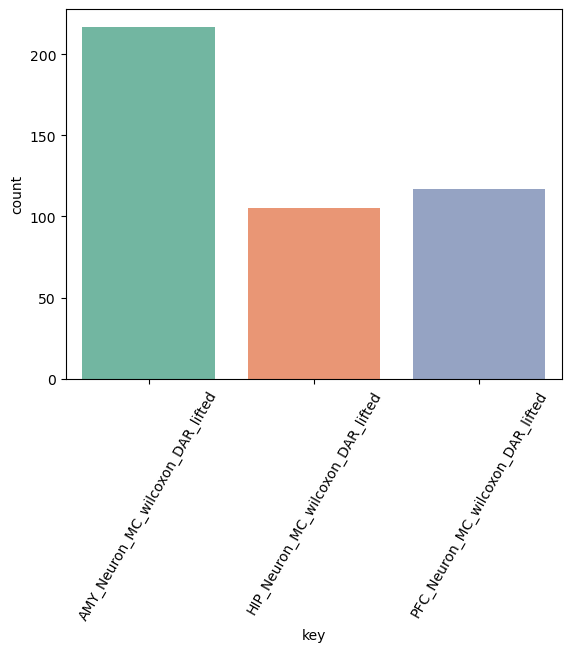

In [234]:
sns.countplot(data=df_TF, x='key', dodge=False, palette='Set2',)
plt.xticks(rotation=60)


In [41]:
for key in dict_table.keys():
    print(len(dict_table[key]))

In [18]:
table

array([(b'metacluster_33.8', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_33.8.png" width="200" >'], [b'Ets1, Chd2, Brca1, Zbtb33, Nr3c1'], [b'Chd2, Zbtb33'], [b'Chd2, Zbtb33'], [b'PFC_Neuron_MC_wilcoxon_DAR_lifted'], [9.35962177e+00, 8.37185105e-02, 4.68050000e+04], [37]),
       (b'metacluster_14.23', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_14.23.png" width="200" >'], [b'Tfe3'], [b'nan'], [b'Srebf1, Tfeb'], [b'PFC_Neuron_MC_wilcoxon_DAR_lifted'], [8.00212294e+00, 7.24099753e-02, 1.47660000e+04], [22]),
       (b'metacluster_57.2', [b'<img src="https://motifcollections.aertslab.org/v10nr_clust/logos/metacluster_57.2.png" width="200" >'], [b'Bach1, Tfeb, Usf2, Mitf, Tfe3'], [b'Mitf, Usf1, Tfe3, Usf2'], [b'Srebf1, Usf1, Bhlhe40, Max, Myc, Arnt, Tfeb, Usf2, Mitf, Bhlhe41, Arntl, Tfe3, Mlx'], [b'PFC_Neuron_MC_wilcoxon_DAR_lifted'], [7.90377667e+00, 7.15907095e-02, 1.15280000e+04], [23]),
       (b'metacluster_14.